## Reference & Credits:

* Please check the content in the original repo -  https://github.com/ishandutta0098/lancedb-multimodal-myntra-fashion-search-engine 
* CLIP paper: https://arxiv.org/abs/2103.00020
* open source clip implementation : https://github.com/mlfoundations/open_clip
* vector db: https://github.com/lancedb/lancedb

## About this notebook: 

* Here we are trying to build an myntra fashion search engine with the help of vector db and openclip . 


## TODO 

* *using PyArrow format directly for Lance Data format \
* using different model 




## Pre-requisites

In [1]:
!pip install lancedb open_clip_torch -Uq

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 15.0.0 which is incompatible.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.1.5 which is incompatible.


In [2]:
# imports 

from pathlib import Path 
from PIL import Image
from random import sample
import os 
import time 

# pydantic
from typing import Any 
from pydantic import BaseModel
import datetime 


# pyarrow
import pyarrow as pa 

# vector db 
import lancedb 
from lancedb.embeddings import EmbeddingFunctionRegistry 
from lancedb.pydantic import LanceModel, Vector  

In [3]:
IMAGE_DATA_PATH = Path(r'/kaggle/input/myntra-fashion-product-dataset/Images/Images')
CSV_PATH = Path(r'/kaggle/input/myntra-fashion-product-dataset/Fashion Dataset.csv')

In [4]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
# file_paths = [str(o) for o in IMAGE_DATA_PATH.glob("*.jpg")]

# valid_fps = set()
# for o in file_paths: 
#     try:
#         if Image.open(o): valid_fps.add(o)
#     except: 
#         print('not valid ', o)
        



In [6]:
def select_embeddings_model(model_name: str = 'open-clip'):
    '''
    by default selects the open-clip model 
    '''
    registry = EmbeddingFunctionRegistry.get_instance()
    model = registry.get(model_name).create()
    return model 


In [7]:
model = select_embeddings_model()

open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [8]:
class Myntra(LanceModel):
    vector: Vector(model.ndims()) = model.VectorField()
    file_path: str = model.SourceField()
        
    @property
    def image(self): return Image.open(self.file_path)

In [9]:
# schema map 

schema_map = {
    'myntra': Myntra
}

In [10]:
# functional schemas


class CreateLanceDBTable(BaseModel):
    database: str 
    table_name: str 
    data_path: Path 
    table_schema: Any
    mode: str 


class LanceDBSearchQuery(BaseModel):
    database: str 
    table_name: str 
    table_schema: Any
    query: Any
    limit: int
    output_path: Path 

In [11]:
def create_lancedb_table(config: CreateLanceDBTable):
    # connect to lancedb
    db = lancedb.connect(config.database)
    
    table_name = None 
    if config.table_name in db: 
        print(f'{config.table_name} exists in lancedb \n\n'.upper())
        table = db[config.table_name]
    if 1:
        start_time = time.time()
        print(f'creating {config.table_name} in lancedb \n\n'.upper())
        
        table = db.create_table(config.table_name, schema=config.table_schema, mode=config.mode)
        
        file_paths = [str(o) for o in config.data_path.glob("*.jpg")]
            
        if not file_paths: return 0 
        
        print(f'total number of images found: {len(file_paths)} \n\n'.upper())
        
#         file_paths = sample(file_paths, 20)
        
        table.add(
            pa.table(
                [file_paths],
                names=['file_path']
                
            )
        )
        
        print(f'total time taken to build {config.table_name} table is {datetime.timedelta(seconds=time.time()-start_time)} \n\n'.upper())
        
        
        

def run_vector_db_search(query: LanceDBSearchQuery):
    if query.output_path.is_dir():
        os.rmdir(str(query.output_path))
    os.makedirs(str(query.output_path))
    
    db = lancedb.connect(query.database)
    
    table = db.open_table(query.table_name)
     
    search_query = Image.open(query.query) if query.query.endswith('.jpg') or query.query.endswith('.png') else query.query
    
    results = table.search(search_query).limit(query.limit).to_pydantic(query.table_schema)
    
    for img in range(query.limit): 
        image_path = query.output_path/f'image_{img}.jpg'
        results[img].image.save(image_path, 'jpeg')


In [12]:
create_lancedb_table(
CreateLanceDBTable(**dict(
    database="/kaggle/working/lancedb",
    table_name="myntra",
    data_path=IMAGE_DATA_PATH,
    table_schema=schema_map.get('myntra'),
    mode='overwrite'
    )
)
)

CREATING MYNTRA IN LANCEDB 




[2024-04-07T16:06:29Z WARN  lance::dataset] No existing dataset at /kaggle/working/lancedb/myntra.lance, it will be created


TOTAL NUMBER OF IMAGES FOUND: 14481 




100%|██████████| 17/17 [00:02<00:00,  7.92it/s]


TOTAL TIME TAKEN TO BUILD MYNTRA TABLE IS 0:30:38.855877 




In [13]:
run_vector_db_search(
    LanceDBSearchQuery(**dict(
        database='/kaggle/working/lancedb',
        table_name='myntra',
        query='white kurta',
        limit=3,
        table_schema=schema_map.get('myntra'),
        output_path=Path('/kaggle/working/output')
    )
                      )
)


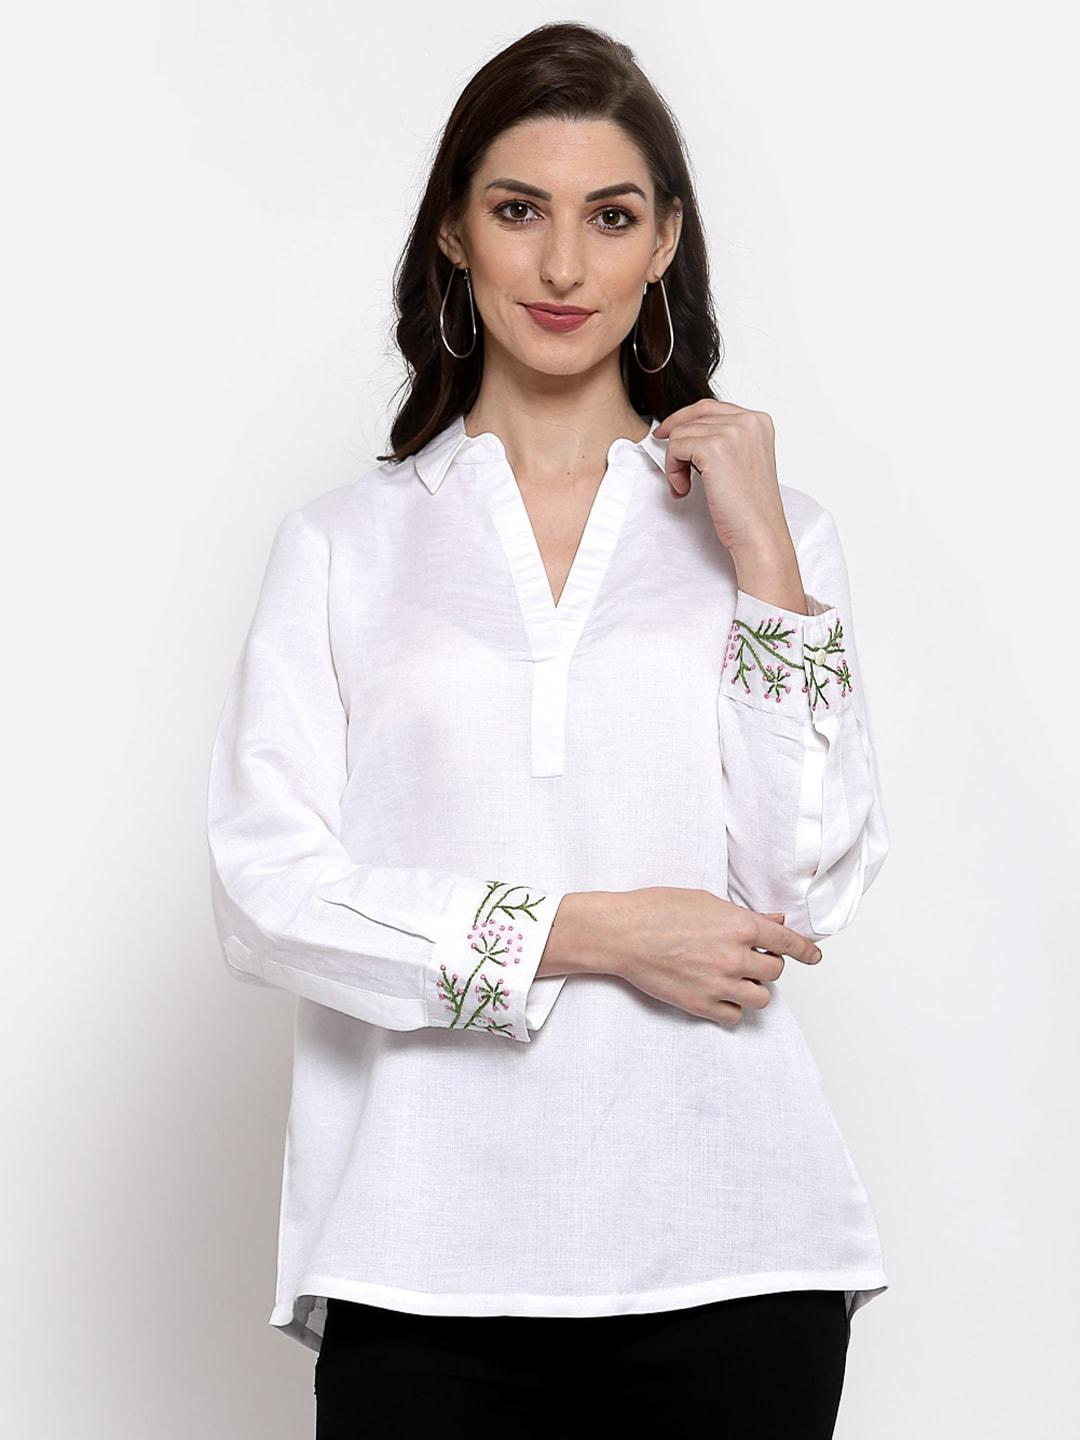

In [14]:
Image.open(r'/kaggle/working/output/image_0.jpg')